# Analyzing the data
So far I'm just playing some randomized samples from each class in the training set, as well as the test sequences, just in order to make it easier to see what we're working with.

## Unzip dataset
In order for this to work on google colab, place the file called 'building_106_kitchen.zip' in the folder called 'content' (likely the one open by default)

In [ ]:
# run once, also runtime may ask to be restarted, that's fine
!pip install rockpool
!pip install --upgrade jax jaxlib
!pip install samna

In [73]:
from zipfile import ZipFile
import os
from IPython.display import Image, Audio, display
import numpy as np
import scipy as sp
import random
import matplotlib.pyplot as plt
from scipy.io import wavfile

from rockpool.devices.xylo.syns61201 import AFESim
from rockpool.devices.xylo.syns65302 import AFESimExternal
from rockpool.timeseries import TimeSeries, TSContinuous
import librosa

In [74]:
zip_file_path = '/content/building_106_kitchen.zip'
extract_path = '/content/dataset'

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## Play sample from each training class


In [ ]:

# path to each training class
train_segments_path = '/content/dataset/building_106_kitchen/training_segments'
class_directories = []
for item in os.listdir(train_segments_path):
    item_path = os.path.join(train_segments_path, item)
    if os.path.isdir(item_path):
        class_directories.append(item)

# one random audio sample from each class
# run this cell again to get different samples
for class_name in class_directories:
    class_path = os.path.join(train_segments_path, class_name)
    wav_files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
    if wav_files:
        random_wav_file = random.choice(wav_files)
        print(f"\nClass: {class_name}")
        display(Audio(os.path.join(class_path, random_wav_file)))


## Play each test sequence

In [ ]:
test_sequence_path = '/content/dataset/building_106_kitchen/test_sequence'
for filename in os.listdir(test_sequence_path):
    if filename.endswith('.wav'):
        file_path = os.path.join(test_sequence_path, filename)
        print(f"\nSequence: {filename}")
        display(Audio(file_path))

# Converting audio data into spike data
I'm likely gonna base this on [this tutorial](https://rockpool.ai/devices/analog-frontend-example.html) from Rockwell documentation on how to convert audio data into spike, though our data is in .wav format so some small extra steps are needed. It seems rockwell wants the audio as a numpy array.

Basically, in the Rockpool library there is AFEsim, a simulation of the analog front-end module of the Xylo Audio 2 device, a piece of neuromorphic hardware, which converts audio frequency bands into spikes. We can use this to convert a .wav file into spike data.

In [122]:
# parameters for AFESim
fs = 110e3                          # The sampling frequency of the input, in Hz
raster_period = 10e-3               # The output rasterisation time-step in seconds
max_spike_per_raster_period = 15    # Maximum number of events per output time-step

# set them false for now
add_noise = False                    # Enables / disables simulated noise generated by the AFE
add_offset = False                   # Add mismatch offset to each filter
add_mismatch = False                 # Add simualted mismatch to filter parameters
seed = None                         # Seed for mistmatch generation

In [123]:
# should input AFESim and path to .wav file and ouput spike representation
def wav_to_spikes(path, afe):
    audio, sr = librosa.load(path, sr=None, mono=True)

    # create a time vector for time series object
    times = np.arange(len(audio)) / sr

    # rockpool continuous time series
    ts_audio = TSContinuous(times, audio[:, None])

    # pass through AFESim
    spikes, state, rec = afe(ts_audio)

    return spikes, state, rec


Class: microwave_door, File: take33.wav


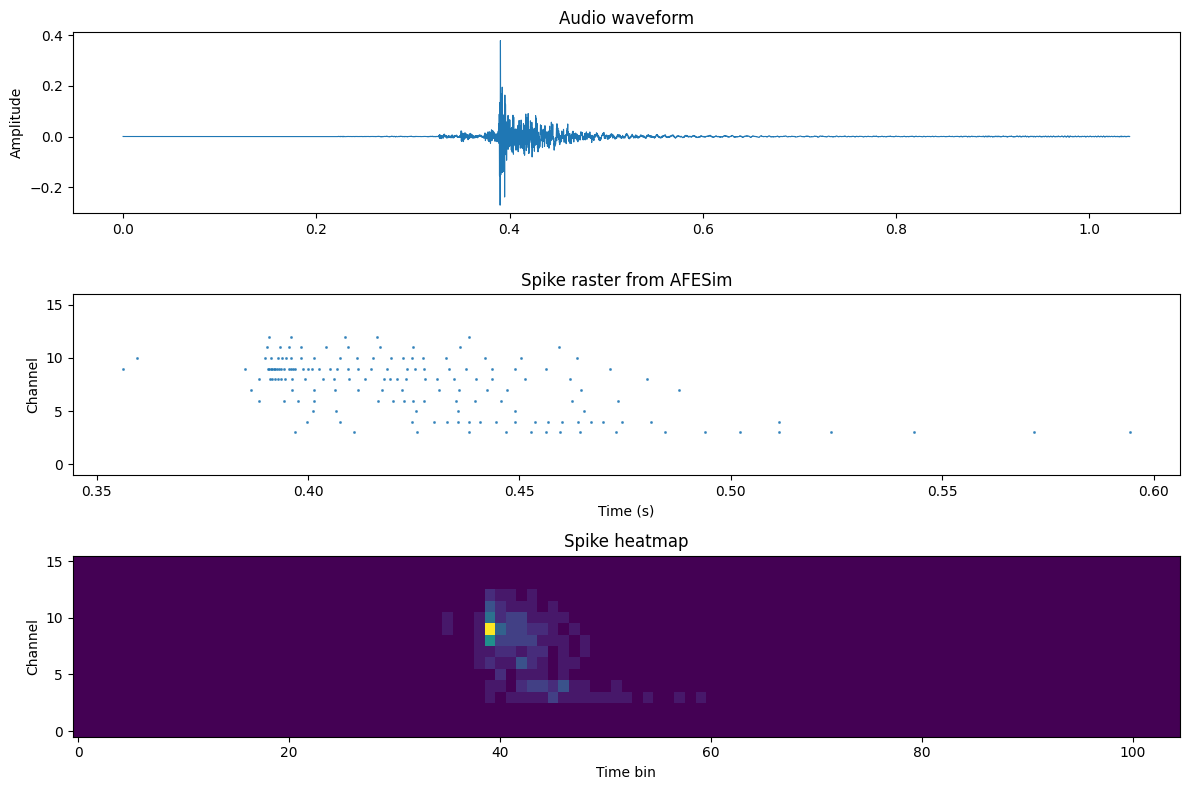

In [127]:
# initialize the AFE simulation
afe = AFESim(
        fs = fs,
        raster_period = raster_period,
        max_spike_per_raster_period = max_spike_per_raster_period,
        add_noise = add_noise,
        add_offset = add_offset,
        add_mismatch = add_mismatch,
        seed = seed,
).timed()

# load one random audio sample
random_class_name = random.choice(class_directories)
random_class_path = os.path.join(train_segments_path, random_class_name)
wav_files_in_random_class = [f for f in os.listdir(random_class_path) if f.endswith('.wav')]
random_audio_file = random.choice(wav_files_in_random_class)

audio_path = os.path.join(random_class_path, random_audio_file)
print(f"Class: {random_class_name}, File: {random_audio_file}")

audio, sr = librosa.load(audio_path, sr=None, mono=True)

# convert to spikes
spike_output, _, _= wav_to_spikes(audio_path, afe)

spike_times = spike_output.times
spike_channels = spike_output.channels

# listen
display(Audio(audio_path))

# waveform plot
fig, ax = plt.subplots(3, 1, figsize=(12, 8), gridspec_kw={'height_ratios':[1,1,1]})

t_audio = np.arange(len(audio)) / sr
ax[0].plot(t_audio, audio, linewidth=0.8)
ax[0].set_title("Audio waveform")
ax[0].set_ylabel("Amplitude")

# spike raster
ax[1].scatter(spike_times, spike_channels, s=5, marker='.', alpha=0.7)
ax[1].set_title("Spike raster from AFESim")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Channel")
ax[1].set_ylim(-1, 16)     # AFESim uses 16 filterbank channels

raster_matrix = spike_output.raster(dt=10e-3, add_events=True)  # 10 ms bins
ax[2].imshow(raster_matrix.T, aspect="auto", origin="lower")
ax[2].set_xlabel("Time bin")
ax[2].set_ylabel("Channel")
ax[2].set_title("Spike heatmap")

plt.tight_layout()
plt.show()

## Note on plot
We can see here that the AFE simulation has 16 outputs, and this is because of a band-pass filter bank which splits the (audio) signal into 16 bands. The lowest band, index 0, has a centre frequency of 40 and the highest band, index 15, has a centre frequency of 16940, as shown in the code cell just below. I believe we should be able to tune the bands if we wanted to. [AFESim documentation](https://rockpool.ai/reference/_autosummary/devices.xylo.syns61201.AFESim.html) shows a bunch of parameters we might be interested in looking at or even tuning.

In [130]:
print("Center frequencies:", afe.module.fcs)

Center frequencies: [   40.    54.    77.   137.   203.   290.   428.   674.  1177.  1700.
  2226.  3418.  5154.  7884. 11630. 16940.]
